In [209]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [210]:
output_file = 'chicken_10_symprob_0.4_rescale_3.0.h5'

simulation_data = {}
with h5py.File(output_file, 'r') as f:
    # Read global attributes
    total_chicken_population = f.attrs['total_chicken_population']
    duck_symptomatic_probability = f.attrs['duck_symptomatic_probability']
    rescale_factor = f.attrs['rescale_factor']

    # Iterate over all other groups (simulations)
    for sim_name in f:
        # Access the simulation group
        sim_group = f[sim_name]
           
        # Check for time and state datasets
        if "time" in sim_group and "state" in sim_group:
            t = sim_group["time"][:]
            y = sim_group["state"][:]
            simulation_data[sim_name] = {
                "time": t,
                "state": y
            }
        else:
            print(f"Warning: Missin6]g 'time' or 'state' in {sim_name}")


In [211]:
def if_outbreak(t, y, outbreak_threshold=5):
    return np.sum(y[-1, :, :, 5:]) >= outbreak_threshold

In [212]:
def find_peak_time(t, y):
    tot_size = np.sum(y[:, :, :, 3:5], axis=(1, 2, 3))
    return t[np.argmax(tot_size)]


In [213]:
def find_start_time(t, y):
    return t[0]

In [222]:
def find_end_time(t, y):
    return t[-1]

In [223]:
def passive_surveillance(t, y, alert_threshold=5):
    threshold_reached = np.where(np.sum(y[:, :, :, 6], axis=(1, 2)) >= alert_threshold)[0]
    if len(threshold_reached) > 0:
        return t[threshold_reached[0]]
    return None

In [216]:
def enhanced_passive_surveillance(t, y, interval=7, chicken=True, duck=True):
    starting_time = np.random.randint(0, interval)
    checking_times = np.arange(starting_time, t[-1], interval)
    for time in checking_times:
        cases = int(chicken) * np.sum(y[np.searchsorted(t, time), :, [0,2], 6]) + int(duck) * np.sum(y[np.searchsorted(t, time), :, [1,3], 6])  
        if cases > 0:
            return time
    return None
    

In [217]:
def active_surveillance(t, y, interval=7, no_test = 10, chicken=True, duck=True):
    starting_time = np.random.randint(0, interval)
    checking_times = np.arange(starting_time, t[-1], interval)
    for time in checking_times:
        cases = int(chicken) * np.sum(y[np.searchsorted(t, time), :, [0,2], 3:5]) + int(duck) * np.sum(y[np.searchsorted(t, time), :, [1,3], 3:5])
        popul_to_test = int(chicken) * total_chicken_population + int(duck) * (40 - total_chicken_population)
        test_array = np.array([1] * int(cases) + [0] * int(popul_to_test - cases))
        if np.sum(np.random.choice(test_array, size=no_test, replace=False)) >= 1:
            return time
    return None

In [218]:
# Initialize a list to store results
results = []

for sim_name, data in simulation_data.items():
    interval = 7
    alert_threshold = 5
    
    # Compute the necessary values
    outbreak = if_outbreak(data["time"], data["state"])
    peak_time = find_peak_time(data["time"], data["state"])
    starting_time = find_start_time(data["time"], data["state"])
    end_time = find_end_time(data["time"], data["state"])
    pas = passive_surveillance(data["time"], data["state"], alert_threshold=alert_threshold)
    eps = enhanced_passive_surveillance(data["time"], data["state"], interval=interval, chicken=True, duck=True)
    acs = active_surveillance(data["time"], data["state"], interval=interval, no_test=10, chicken=True, duck=True)

    # Append the computed values to the list
    results.append([sim_name, outbreak, starting_time, peak_time, end_time, pas, eps, acs])

# Create a DataFrame in one go
df = pd.DataFrame(results, columns=["simulation", "outbreak", "starting_time", "peak_time", "end_time",
                                    "passive_surveillance", "enhanced_passive_surveillance", 
                                    "active_surveillance"])


In [219]:
df.head(10)

,simulation,outbreak,starting_time,peak_time,end_time,passive_surveillance,enhanced_passive_surveillance,active_surveillance
0,simulation_1,True,0.0,4.308031,35.798638,3.192353,5.0,28.0
1,simulation_10,True,0.0,3.545469,67.224255,3.451948,2.0,9.0
2,simulation_100,True,0.0,3.579663,42.422570,3.642411,3.0,2.0
3,simulation_1000,True,0.0,3.354273,72.948737,3.866172,5.0,20.0
4,simulation_1001,True,0.0,3.874885,68.044997,4.061890,4.0,6.0
5,simulation_1002,True,0.0,4.084921,32.079644,2.669069,7.0,3.0
6,simulation_1003,True,0.0,2.966832,121.330785,2.689487,5.0,41.0
7,simulation_1004,True,0.0,3.404911,51.335203,3.175064,6.0,5.0
8,simulation_1005,True,0.0,3.961295,49.398230,3.162484,4.0,4.0
9,simulation_1006,True,0.0,4.230166,82.558179,3.768556,5.0,3.0


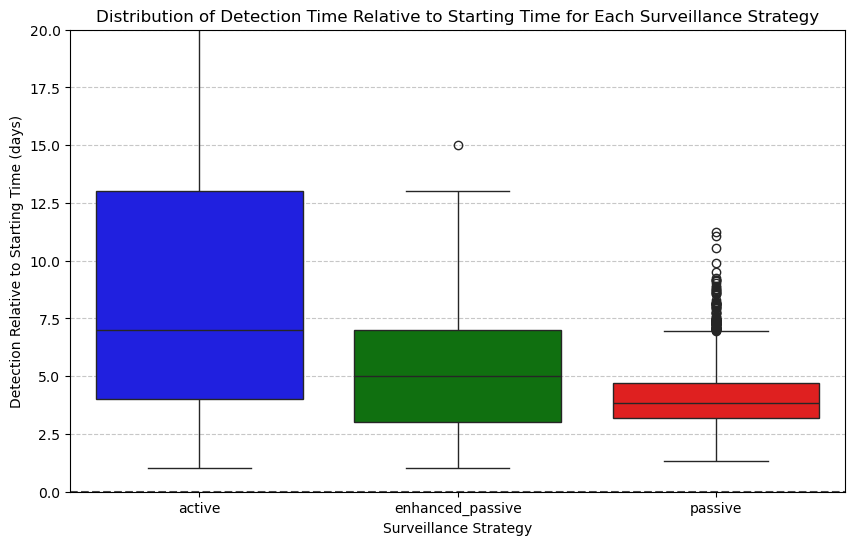

In [220]:
# Assuming 'df' contains the full dataset
# Filter for outbreak cases only
df_outbreaks = df[df["outbreak"] == True].copy()

# Replace NaN values in detection strategies with the corresponding end_time value
df_outbreaks["passive_surveillance"] = df_outbreaks["passive_surveillance"].fillna(df_outbreaks["end_time"])
df_outbreaks["enhanced_passive_surveillance"] = df_outbreaks["enhanced_passive_surveillance"].fillna(df_outbreaks["end_time"])
df_outbreaks["active_surveillance"] = df_outbreaks["active_surveillance"].fillna(df_outbreaks["end_time"])

# Compute detection time relative to the end time
df_outbreaks["passive"] = df_outbreaks["passive_surveillance"] - df_outbreaks["starting_time"]
df_outbreaks["enhanced_passive"] = df_outbreaks["enhanced_passive_surveillance"] - df_outbreaks["starting_time"]
df_outbreaks["active"] = df_outbreaks["active_surveillance"] - df_outbreaks["starting_time"]

# Melt the DataFrame for easier plotting
df_melted = df_outbreaks.melt(id_vars=["simulation"], 
                              value_vars=["active", "enhanced_passive", "passive"],
                              var_name="Surveillance Strategy", 
                              value_name="Detection Relative to End Time (days)")

# Create the box plot with colors (assign x variable to hue)
plt.figure(figsize=(10, 6))
sns.boxplot(x="Surveillance Strategy", y="Detection Relative to End Time (days)", 
            data=df_melted, hue="Surveillance Strategy", 
            palette=["blue", "green", "red"])

# Labels and title
plt.xlabel("Surveillance Strategy")
plt.ylabel("Detection Relative to Starting Time (days)")
plt.title("Distribution of Detection Time Relative to Starting Time for Each Surveillance Strategy")
plt.axhline(0, color="black", linestyle="--", alpha=0.7)  # Show zero line for reference
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim([0,20])


plt.show()

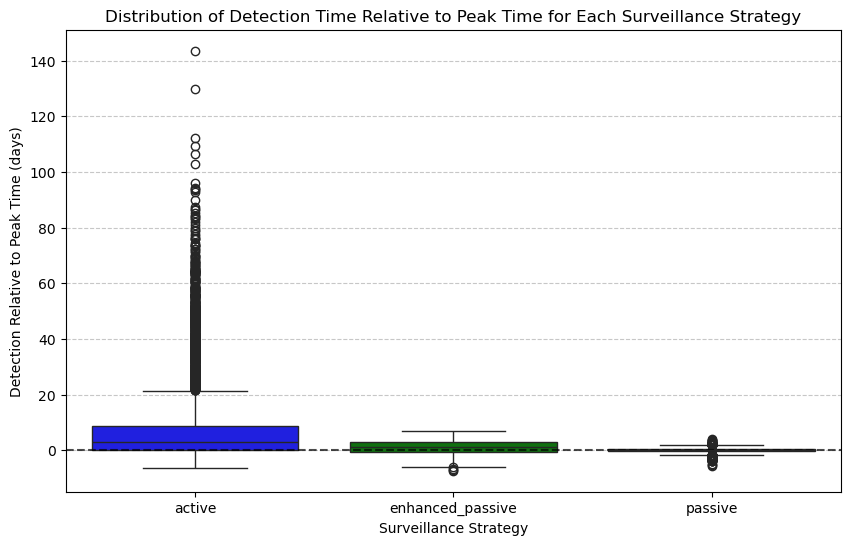

In [221]:

# Assuming 'df' contains the full dataset
# Filter for outbreak cases only
df_outbreaks = df[df["outbreak"] == True].copy()

# Replace NaN values in detection strategies with the corresponding peak_time value
df_outbreaks["passive_surveillance"] = df_outbreaks["passive_surveillance"].fillna(df_outbreaks["end_time"])
df_outbreaks["enhanced_passive_surveillance"] = df_outbreaks["enhanced_passive_surveillance"].fillna(df_outbreaks["end_time"])
df_outbreaks["active_surveillance"] = df_outbreaks["active_surveillance"].fillna(df_outbreaks["end_time"])

# Compute detection time relative to the peak time
df_outbreaks["passive"] = df_outbreaks["passive_surveillance"] - df_outbreaks["peak_time"]
df_outbreaks["enhanced_passive"] = df_outbreaks["enhanced_passive_surveillance"] - df_outbreaks["peak_time"]
df_outbreaks["active"] = df_outbreaks["active_surveillance"] - df_outbreaks["peak_time"]

# Melt the DataFrame for easier plotting
df_melted = df_outbreaks.melt(id_vars=["simulation"], 
                              value_vars=["active", "enhanced_passive", "passive"],
                              var_name="Surveillance Strategy", 
                              value_name="Detection Relative to Peak Time (days)")

# Create the box plot with colors (assign x variable to hue)
plt.figure(figsize=(10, 6))
sns.boxplot(x="Surveillance Strategy", y="Detection Relative to Peak Time (days)", 
            data=df_melted, hue="Surveillance Strategy", 
            palette=["blue", "green", "red"])

# Labels and title
plt.xlabel("Surveillance Strategy")
plt.ylabel("Detection Relative to Peak Time (days)")
plt.title("Distribution of Detection Time Relative to Peak Time for Each Surveillance Strategy")
plt.axhline(0, color="black", linestyle="--", alpha=0.7)  # Show zero line for reference
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()
